# 2D velocity distribution

In [33]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 100
v = linspace(0,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*233.0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../FitShards_red.csv')
print df
names = df.ID
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun

         ID       vx       vy       vz     sigx    sigy     sigz  population
0        S1   -8.600 -286.700  -67.900  115.300  49.900   60.000        34.0
1       Rg1   54.100 -393.800   68.300  147.200  45.700  149.400        20.0
2       Rg2   47.800 -254.600   71.800  110.200  27.800  172.100        20.0
3       Rg3   28.000 -275.100   18.000  186.000  62.700  136.500        16.0
4       Rg4  177.600 -287.900  117.900  114.600  46.000  162.700        13.0
5       Rg5  -10.000  -82.300   -0.600   83.200  21.200  162.700        29.0
6       Rg6  -11.900 -222.100   88.000  187.600  44.000  134.900        30.0
7       Rg7  -92.300 -160.200  -33.400  274.600  66.500  178.100        14.0
8        S2  -11.200  159.600 -166.500   65.600  21.900  151.700        73.0
9        C2 -242.400  109.900  180.700  229.200  35.900  236.100        22.0
10    Cand8    8.200  192.000  -25.000  124.000  40.200  186.600        49.0
11    Cand9   48.400  164.500 -171.100  139.600  24.200  172.000        44.0

In [41]:
v_esc = 528.0
v_lab = array([11.1,220+12.24,7.25])
nn = 100
ni = 500
fv2_Iso = zeros(shape=(nn,nn))
fv2_Saus = zeros(shape=(nn,nn))
vr = linspace(-600,600,nn)
vth = linspace(-800,200,nn)
v = zeros(shape=(ni,3))
vmax = v_esc + sqrt(sum(v_lab**2.0))

for i in range(0,nn):
    for j in range(0,nn):
        vzmax = vmax**2.0-vr[i]**2.0-vth[j]**2.0
        if vzmax>0.0:
            vzmax = sqrt(vzmax)
            vz = linspace(-vzmax,vzmax,ni)
            v[:,0] = vr[i]
            v[:,1] = vth[j]
            v[:,2] = vz
            fv2_Iso[i,j] = trapz(VelocityDist_Isotropic(v,day),vz)
            fv2_Saus[i,j] = trapz(VelocityDist_Triaxial(v,day,sig_beta),vz)
            
fv2_Shards = zeros(shape=(nn,nn,nshards))
for k in range(0,nshards):
    v_s = velocities[k,:]
    sig_s = dispersions[k,:]
    vmax = v_esc + sqrt(sum((v_lab-v_s)**2.0))
    for i in range(0,nn):
        for j in range(0,nn):
            vzmax = vmax**2.0-vr[i]**2.0-vth[j]**2.0
            if vzmax>0.0:
                vzmax = sqrt(vzmax)
                vz = linspace(-vzmax,vzmax,ni)
                v[:,0] = vr[i]
                v[:,1] = vth[j]
                v[:,2] = vz
                fv2_Shards[i,j,k] = pops[k]*trapz(VelocityDist_Triaxial(v,day,sig_s,v_shift=v_s),vz)

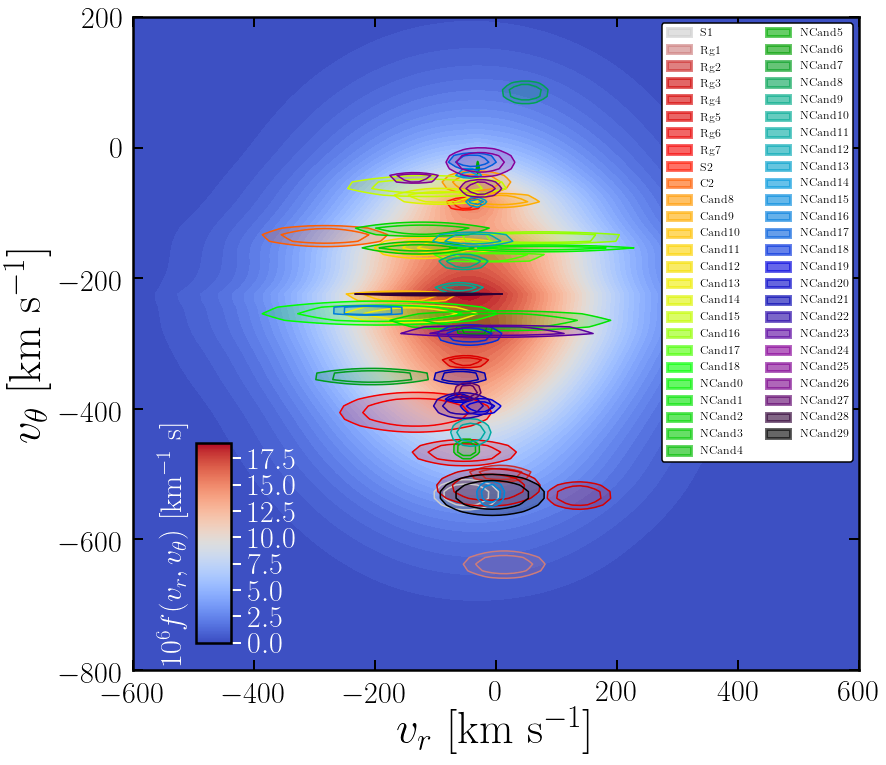

In [42]:
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_fv2'        
       
xi_aniso = 0.6
xi_iso = 1.0-xi_aniso
fv2_total = xi_iso*fv2_Iso + (xi_aniso/2.0)*(fv2_Saus+sum(fv2_Shards,2))
plt.contourf(vr,vth,transpose(fv2_total)*1e6,50,cmap=cm.coolwarm)

for i in range(0,nshards):
    f2 = transpose(fv2_Shards[:,:,i])
    plt.contourf(vr,vth,f2,levels=[amax(f2)*0.9,amax(f2)*0.95,amax(f2)],alpha=0.2,colors=((colstrs[i,:]),),linewidth=3)
    plt.contour(vr,vth,f2,levels=[amax(f2)*0.9,amax(f2)*0.95,amax(f2)],colors=((colstrs[i,:]),),linewidth=3)
    plt.fill_between([-10000,-10000],[0,1],linewidth=3,alpha=0.6,color=colstrs[i,:],label=names[i])
leg = plt.legend(loc='upper right',fontsize=12,edgecolor='k',framealpha=1.0,ncol=2)
leg.get_frame().set_linewidth(1.5)

vmin = amin(fv2_total)*1e6
vmax = amax(fv2_total)*1e6

# Plot fiddling
plt.xlim([-600,600])
plt.ylim([-800,200])
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v_r$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$v_\theta$ [km s$^{-1}$]",fontsize=45);

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-480, -60, 700, 400]) 
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes)
f = plt.gcf().get_children()
cbar = f[2]
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
cbar.set_ylabel(r'$10^6 f(v_r,v_\theta)$ [km$^{-1}$ s]')
cbar.yaxis.label.set_size(30)
cbar.yaxis.set_label_position("left")
cbar.yaxis.label.set_color('w')
cbar.xaxis.label.set_color('w')
cbar.tick_params(axis='x', colors='w')
cbar.tick_params(axis='y', colors='w')
cbar.spines['bottom'].set_color('w')
cbar.spines['top'].set_color('w') 
cbar.spines['right'].set_color('w')
cbar.spines['left'].set_color('w')

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

